# Metadata

```
Course:   DS 5001
Module:   08 HW
Topic:    Prepare OKCupid Corpus
Author:   R.C. Alvarado
```

# Set Up

In [5]:
data_home = '../data'
local_lib = '../lib'

In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.tag import StanfordPOSTagger

In [4]:
CORPUS = pd.read_csv(f'{data_home}/{data_prefix}/{data_prefix}-CORPUS.csv').set_index(OHCO)

FileNotFoundError: [Errno 2] No such file or directory: '../data/okcupid/okcupid-CORPUS.csv'

In [ ]:
# Gather sentences 
SENTS = CORPUS.groupby(OHCO[:-1]).term_str.apply(lambda x: x.str.cat(sep=' '))

In [ ]:
from nltk.parse import CoreNLPParser

def tag_sents(SENTS):

    pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

    input_sents = [sent.split() for sent in SENTS.values]
    parsed_sents = [pos_tagger.tag(sent) for sent in tqdm(input_sents)]

    TOKEN = pd.DataFrame(parsed_sents, index=SENTS.index).stack().to_frame()
    # TOKEN.index.names = OHCO
    TOKEN['term_str'] = TOKEN[0].apply(lambda x: x[0], 1)
    TOKEN['pos'] = TOKEN[0].apply(lambda x: x[1], 1)
    TOKEN = TOKEN.iloc[:, 1:] # Drop first col
    
    return TOKEN

In [ ]:
# TOKENS = tag_sents(SENTS)

In [ ]:
T2 = TOKENS[~TOKENS.pos.str.match(r'NNPS?')]

In [ ]:
# T2

In [ ]:
TOKENS.pos.value_counts(ascending=True).plot.barh(figsize=(5,15));

# Import Corpus

In [8]:
src_file = '~/Dropbox/CODE/polo-pub/PUB/okcupid/corpus/profiles.csv'

In [9]:
OKC = pd.read_csv(src_file)
essay_cols = [col for col in OKC.columns if 'essay' in col]
OKC['doc_raw'] = OKC[essay_cols].apply(lambda x: ' '.join(x.values.astype(str)), axis=1)
OKC = OKC.drop(essay_cols, axis=1)
OKC['doc_clean'] = OKC.doc_raw.str.replace(r"<[^>]+>", "", regex=True)
OKC['doc_clean'] = OKC.doc_clean.str.replace(r'&[^&;]+;', ' ', regex=True)
OKC['doc_clean'] = OKC.doc_clean.str.replace(r"\n+", " ", regex=True)
OKC['doc_clean'] = OKC.doc_clean.str.replace(r"\W+", " ", regex=True)
OKC['doc_clean'] = OKC.doc_clean.str.replace(r"\s+", " ", regex=True)
OKC.index.name = 'doc_id'

In [10]:
OKC.to_csv("../data/okcupid/okcupid-DOC.csv", index=True)

# Balance and Reduce by Sex

In [11]:
OKC.loc[(OKC.income > 0) & (OKC.age > 0)].sex.value_counts()

m    8391
f    3113
Name: sex, dtype: int64

In [12]:
M = OKC.loc[(OKC.income > 0) & (OKC.sex=='m')].sample(3000)
F = OKC.loc[(OKC.income > 0) & (OKC.sex=='f')].sample(3000)
MF = pd.concat([M, F])

In [13]:
# MF

# Tokenize and Tag with Stanford CoreNLP

* See https://stanfordnlp.github.io/CoreNLP/corenlp-server.html 

In [15]:
from nltk.parse import CoreNLPParser
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

In [16]:
def tag_sents(SENTS):

    pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

    input_sents = [sent.split() for sent in SENTS.values]
    parsed_sents = [pos_tagger.tag(sent) for sent in tqdm(input_sents)]

    TOKEN = pd.DataFrame(parsed_sents, index=SENTS.index).stack().to_frame()
    TOKEN['term_str'] = TOKEN[0].apply(lambda x: x[0], 1)
    TOKEN['pos'] = TOKEN[0].apply(lambda x: x[1], 1)
    TOKEN = TOKEN.iloc[:, 1:] # Drop first col
    
    return TOKEN

In [17]:
OKC_TOKEN = tag_sents(MF.doc_clean)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [03:51<00:00, 25.89it/s]


# Filter by POS and SW

In [20]:
OKC_TOKEN_REDUCED = OKC_TOKEN[OKC_TOKEN.pos.isin(['NN','NNS','VB','VBP','VBD','VBN','VBP','VBZ'])]
OKC_BOW = OKC_TOKEN_REDUCED.reset_index().value_counts(['doc_id','term_str']).to_frame('n')
OKC_BOW = OKC_BOW.sort_index()

In [21]:
OKC_BOW.sample(5)

,,n
doc_id,term_str,
36560,literature,1
34161,animals,1
7515,lives,1
1472,avocados,1
17311,shorties,2


# VOCAB

In [22]:
import re

In [23]:
swlist = stopwords.words('english')

In [24]:
OKC_VOCAB = OKC_BOW.groupby('term_str').n.sum().to_frame('n')
OKC_VOCAB['n_chars'] = OKC_VOCAB.apply(lambda x: len(x.name), 1)
OKC_VOCAB['has_num'] = OKC_VOCAB.apply(lambda x: re.search(r'\d+', x.name), 1).astype('bool').astype('int')
OKC_VOCAB['stop'] = OKC_VOCAB.apply(lambda x: x.name in swlist, 1).astype('int')
OKC_VOCAB['is_cool'] = OKC_VOCAB.apply(lambda x: re.match(r'^[a-z]+$', str(x.name)), 1).astype('bool').astype('int')

In [25]:
OKC_VOCAB_REDUCED = OKC_VOCAB[
      (OKC_VOCAB.stop == 0) 
    & (OKC_VOCAB.n_chars > 2) 
    & (OKC_VOCAB.n_chars < 10) 
    & (OKC_VOCAB.has_num == 0) 
    & (OKC_VOCAB.is_cool == 1)]

In [26]:
OKC_BOW2 = OKC_BOW.reset_index().merge(OKC_VOCAB_REDUCED, on='term_str')\
    .query("stop == False").set_index(['doc_id','term_str']).n_x.to_frame('n')

In [27]:
len(OKC_BOW), len(OKC_BOW2)

(704645, 597725)

In [28]:
OKC_BOW2.sort_index()

n
doc_id term_str   
1      acts      1
       amonts    1
       anything  1
       ass       2
       badass    1
...             ..
59934  worked    1
       world     2
       year      1
       years     3
       yoga      1

[597725 rows x 1 columns]

# Model (Test)

In [29]:
import sys; sys.path.append(local_lib)

In [30]:
from topicmodel import TopicModel

In [31]:
okc_tm = TopicModel(OKC_BOW2)
okc_tm.n_topics = 40
okc_tm.n_terms = 2000
okc_tm.create_X()
okc_tm.get_model()
okc_tm.describe_topics()
okc_tm.get_model_stats()

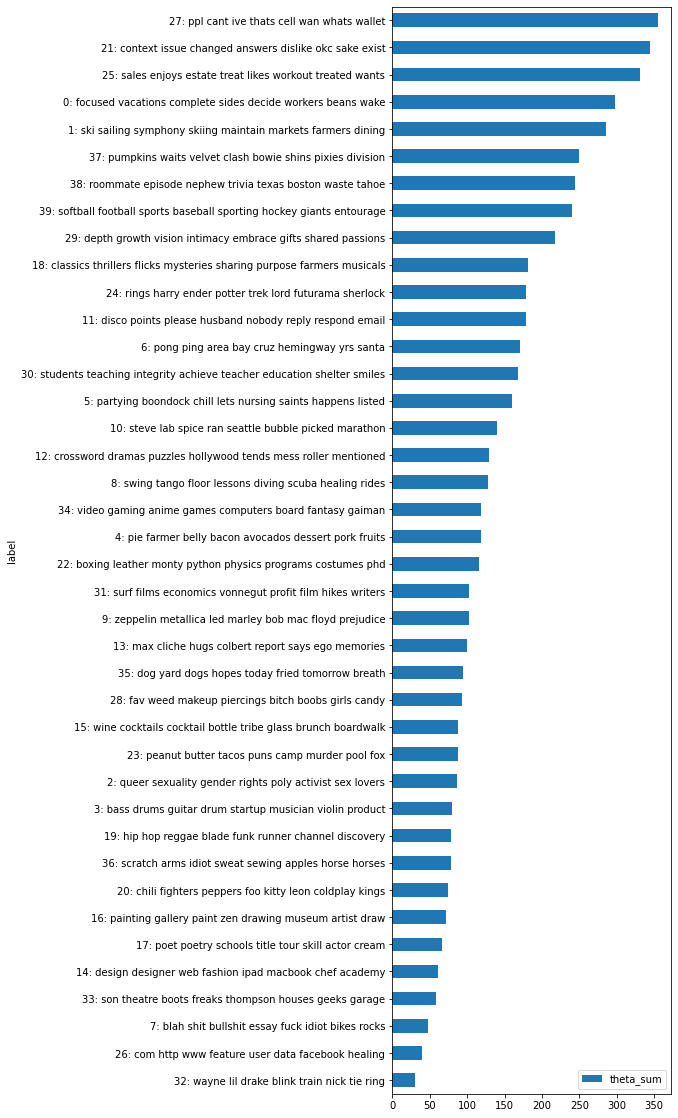

In [33]:
okc_tm.plot_topics()

In [36]:
OKC.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity',
       'height', 'income', 'job', 'last_online', 'location', 'offspring',
       'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes', 'speaks',
       'status', 'doc_raw', 'doc_clean'],
      dtype='object')

In [54]:
G = {}
for group_col in ['age','sex','income', 'status', 'orientation', 'body_type']:
    G[group_col] = okc_tm.THETA.join(OKC[group_col]).groupby(group_col).mean()

In [55]:
G['body_type'].T.style.background_gradient(cmap='GnBu', axis=None)

body_type,a little extra,athletic,average,curvy,fit,full figured,jacked,overweight,rather not say,skinny,thin,used up
0,0.057956,0.048183,0.056998,0.047808,0.051458,0.055914,0.033239,0.041335,0.053172,0.043549,0.048596,0.026953
1,0.034279,0.055253,0.049808,0.051319,0.065491,0.037144,0.023694,0.016718,0.026581,0.029565,0.041092,0.013797
2,0.015327,0.013695,0.013228,0.015035,0.012015,0.023465,0.016202,0.014726,0.021719,0.018925,0.016657,0.033614
3,0.012125,0.017767,0.012044,0.010586,0.013703,0.010606,0.021582,0.005655,0.009353,0.012721,0.018099,0.023101
4,0.016486,0.018961,0.018004,0.021541,0.021436,0.013670,0.025382,0.018642,0.017212,0.028315,0.021159,0.033643
5,0.035026,0.029628,0.028373,0.026176,0.025882,0.023841,0.032801,0.017534,0.023703,0.048326,0.021279,0.016575
6,0.033650,0.036326,0.030125,0.024418,0.029181,0.013722,0.013791,0.011670,0.027103,0.034492,0.030520,0.020758
7,0.009527,0.009101,0.006608,0.008498,0.006674,0.004630,0.026203,0.001954,0.004104,0.020266,0.006047,0.028247
8,0.010490,0.028729,0.016133,0.019814,0.028240,0.022611,0.020456,0.014821,0.016035,0.026232,0.023031,0.007909
9,0.016230,0.018753,0.017118,0.015261,0.019432,0.006382,0.033631,0.024430,0.004676,0.016605,0.017078,0.044433


In [57]:
okc_tm.TOPIC.loc[27].top_terms_rel

'ppl cant ive thats cell wan whats wallet'

In [53]:
G['orientation'].T.style.background_gradient(cmap='GnBu', axis=None)

orientation,bisexual,gay,straight
0,0.030916,0.050297,0.053296
1,0.016847,0.034657,0.053506
2,0.041503,0.038853,0.010462
3,0.014663,0.007616,0.014144
4,0.024505,0.028769,0.019466
5,0.032512,0.032811,0.026842
6,0.015929,0.025685,0.031005
7,0.011652,0.007473,0.007860
8,0.031200,0.019965,0.021443
9,0.012679,0.012963,0.018510


In [52]:
okc_tm.TOPIC.loc[21].top_terms_rel

'context issue changed answers dislike okc sake exist'

In [48]:
G['status'].T.style.background_gradient(cmap='GnBu', axis=None)

status,available,married,seeing someone,single,unknown
0,0.052588,0.020285,0.041665,0.052069,0.004762
1,0.020276,0.009262,0.013679,0.052780,0.004762
2,0.058808,0.024741,0.026099,0.012246,0.130683
3,0.013964,0.006131,0.013336,0.013782,0.004762
4,0.019502,0.019721,0.029337,0.020131,0.004762
5,0.017670,0.034467,0.031473,0.027916,0.004762
6,0.015733,0.008107,0.017122,0.030883,0.004762
7,0.004985,0.001691,0.008273,0.008305,0.004762
8,0.045809,0.018489,0.023500,0.020991,0.004762
9,0.013118,0.010503,0.016317,0.017994,0.004762


In [49]:
okc_tm.TOPIC.loc[35].top_terms_rel

'dog yard dogs hopes today fried tomorrow breath'

# Save

In [ ]:
DOCIDX = OKC_BOW2.sort_index().unstack().index

In [ ]:
# OKC.loc[DOCIDX].to_csv(f"../data/okcupid/okcupid-LIB.csv")

In [ ]:
# OKC_BOW2.sort_index().to_csv(f"../data/okcupid/okcupid-BOW.csv")